In [22]:
from bs4 import BeautifulSoup
import requests
import re
import json
import time
import random
import os
from collections import defaultdict
import dateutil.parser
from datetime import datetime
import pandas as pd
import pickle
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns


# Steps
- Examine and explore the data   
  - Look at the data. If you can examine all of it in detail that is ideal. If dataset is very large, this may be unwieldy, so look at all of data in aggregated form (what is data type, how many entries are there, etc.) and examine a random subset in detail. Make sure the data is clean (remove NaN, for example) and meaningful (e.g., if the number of customers is negative, there is a problem).
     
  - Look at statistics: Correlation matrix, seaborn plots (to check for colinearity; compare what you see with human intuition) and probability distributions. Linear regression will typically see more success if the target variable has a fairly symmetric distribution (e.g., it might look close to a normal distribution). Look at the residual vs. y_pred plot for any weirdness (for example, due to bimodal distribution). 
  
- Baselining. Look at one feature (you might get lucky and this is THE feature needed to explain your observations). You can see the fit immediately from the seaborn plot. Run statsmodels or sklearn to look at R^2, etc.
- Expand model. Run it with a few features (3 or 4), so it is still humanly interpretable. Plot distribution of target variable, errors vs. predicted value to see if non-linearity or heteroskedasticity are an issue. Check fit of the model. Possibly run statsmodels to calculate p-values and see if they correspond to your intuition.
- Complete model. Run with all features and run same diagnostics. Do you need all of the features or can you discard some of them? Are the coefficients (betas) statistically significant? Make sure you understand the diagnostics to know if your p-values are trustworthy or not.
- Validate model. Set up a validation scheme, preferably cross-validation if you have the computational resources as it is more robust. Using your validation scheme, you can perform iterative feature selection/expansion/engineering and model complexity adjustments in order to complete the next 2 steps.
- Challenge model. Do you need more complexity or less? Do you need a fancier model (nonlinear, additional feature engineering / transformations e.g. polynomial)? Hopefully at this point you have an understanding of where you need to go by knowing the bias vs. variance tradeoff.
- Refine model. Add or remove complexity (using a more sophisticated model or making your model more conservative by using regularization). Compare with unrefined model (error vs. y_pred, R^2, MAE, RMSE). Use regularization to fine tune model (Ridge, Lasso; Lasso may eliminate coefficients that you included at first).
- Test model. How does your final, refined model perform on out-of-sample data? If it does well, hurray! If not, linear regression (with this data set) may not be the answer and you have to move to find more features, more data, or more complex models that are harder to interpret.



In [25]:
%matplotlib inline

pd.set_option('display.max_columns', 500)
sns.set()

In [95]:
df = pd.read_pickle('/Users/kirill.kogan/Documents/data/metis_p02_kickstarter/pickles/kickstarter_cat_34.pkl')

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11607 entries, 0 to 11606
Data columns (total 33 columns):
backers_count               11607 non-null int64
base_id                     11607 non-null int64
blurb                       11607 non-null object
category_id                 11607 non-null int64
category_parent_id          11607 non-null int64
category_slug               11607 non-null object
converted_pledged_amount    11607 non-null int64
country                     11607 non-null object
created_at                  11607 non-null datetime64[ns]
creator_id                  11607 non-null int64
creator_url                 11607 non-null object
deadline                    11607 non-null datetime64[ns]
fx_rate                     11607 non-null float64
goal                        11607 non-null float64
is_flagged_spotlight        11607 non-null bool
launched_at                 11607 non-null datetime64[ns]
location_country            11604 non-null object
location_id            

In [97]:
df.drop_duplicates(inplace=True, subset='profile_project_id')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10563 entries, 0 to 11606
Data columns (total 33 columns):
backers_count               10563 non-null int64
base_id                     10563 non-null int64
blurb                       10563 non-null object
category_id                 10563 non-null int64
category_parent_id          10563 non-null int64
category_slug               10563 non-null object
converted_pledged_amount    10563 non-null int64
country                     10563 non-null object
created_at                  10563 non-null datetime64[ns]
creator_id                  10563 non-null int64
creator_url                 10563 non-null object
deadline                    10563 non-null datetime64[ns]
fx_rate                     10563 non-null float64
goal                        10563 non-null float64
is_flagged_spotlight        10563 non-null bool
launched_at                 10563 non-null datetime64[ns]
location_country            10560 non-null object
location_id            

In [99]:
df.describe()

,backers_count,base_id,category_id,category_parent_id,converted_pledged_amount,creator_id,fx_rate,goal,location_id,percent_funded,pledged,profile_project_id,usd_pledged
count,10563.000000,1.056300e+04,10563.0,10563.0,1.056300e+04,1.056300e+04,10563.000000,1.056300e+04,1.056000e+04,1.056300e+04,1.056300e+04,1.056300e+04,1.056300e+04
mean,865.605699,1.073541e+09,34.0,12.0,6.746052e+04,1.079246e+09,1.002523,1.243621e+04,2.797428e+06,2.275317e+03,7.436373e+04,2.700932e+06,6.751367e+04
std,3229.067558,6.216240e+08,0.0,0.0,2.945993e+05,6.232037e+08,0.174899,4.469103e+04,5.037582e+06,4.640750e+04,3.161897e+05,9.339071e+05,2.948168e+05
min,1.000000,3.923500e+04,34.0,12.0,8.000000e+00,4.223010e+05,0.009313,1.000000e+00,3.210000e+02,1.000000e+02,8.000000e+00,1.484000e+03,8.000000e+00
25%,96.000000,5.299131e+08,34.0,12.0,4.003000e+03,5.458201e+08,1.000000,1.000000e+03,7.790630e+05,1.516750e+02,4.002770e+03,2.216520e+06,4.009899e+03
50%,252.000000,1.083914e+09,34.0,12.0,1.242200e+04,1.081689e+09,1.000000,5.000000e+03,2.401184e+06,2.985000e+02,1.242700e+04,2.975688e+06,1.242700e+04
75%,720.000000,1.610657e+09,34.0,12.0,3.776250e+04,1.620165e+09,1.000000,1.241350e+04,2.473224e+06,6.942050e+02,3.956375e+04,3.423805e+06,3.792578e+04
max,219382.000000,2.147389e+09,34.0,12.0,1.239314e+07,2.146601e+09,1.229370,2.200000e+06,5.604400e+07,3.284300e+06,1.239314e+07,3.819693e+06,1.239314e+07


In [100]:
df.head()

,backers_count,base_id,blurb,category_id,category_parent_id,category_slug,converted_pledged_amount,country,created_at,creator_id,creator_url,deadline,fx_rate,goal,is_flagged_spotlight,launched_at,location_country,location_id,location_name,name,percent_funded,pledged,profile_external_url,profile_project_id,profile_state,profile_state_changed_at,slug,staff_pick,state,state_changed_at,url_project,url_rewards,usd_pledged
0,181,592551458,More High Fantasy inspired soundscapes for gam...,34,12,games/tabletop games,6734,US,2014-02-21 02:35:10,1766442648,https://www.kickstarter.com/profile/strangelette,2014-11-22 19:36:51,1.00000,1000.0,True,2014-10-23 18:36:51,United States,2466256.0,"Orlando, FL",Epic Fantasy Soundtracks II: Tabletop Gaming S...,673.400000,6734.0,None,899458,inactive,2015-03-09 15:44:09,epic-fantasy-soundtracks-ii-tabletop-gaming-so...,False,successful,2014-11-22 19:36:52,https://www.kickstarter.com/projects/strangele...,https://www.kickstarter.com/projects/strangele...,6734.000000
1,147,1573096498,A card game of deduction and dirty tricks for ...,34,12,games/tabletop games,3347,US,2014-10-17 13:32:54,256517189,https://www.kickstarter.com/profile/256517189,2014-11-19 19:00:00,1.00000,1000.0,True,2014-10-28 14:10:48,United States,2396300.0,"East Walpole, MA",Truths Too Terrible,334.700000,3347.0,http://www.amazon.com/gp/product/B00UZLJ6LS,1447772,active,2015-03-23 17:37:55,truths-too-terrible,False,successful,2014-11-19 19:00:12,https://www.kickstarter.com/projects/256517189...,https://www.kickstarter.com/projects/256517189...,3347.000000
2,24,733303305,"The next unit in my Orc range, this time the B...",34,12,games/tabletop games,1440,GB,2014-10-13 09:54:06,231062375,https://www.kickstarter.com/profile/231062375,2014-11-18 08:57:18,1.22937,600.0,True,2014-10-19 07:57:18,United Kingdom,12695981.0,"Stevenage Borough, UK",Orc Bowmen 28mm miniatures,153.333333,920.0,None,1435632,inactive,2015-03-09 15:44:39,orc-bowmen-28mm-miniatures,False,successful,2014-11-18 08:57:19,https://www.kickstarter.com/projects/231062375...,https://www.kickstarter.com/projects/231062375...,1480.489723
3,67,365147754,Resin wargaming models scaled to fit with 28 t...,34,12,games/tabletop games,4430,GB,2014-10-29 08:58:26,179741323,https://www.kickstarter.com/profile/179741323,2014-11-13 15:43:08,1.22937,500.0,True,2014-10-29 14:43:08,United Kingdom,30720.0,"Nottingham, UK",Minimus Squat's Bounty Hunter Crew,561.800000,2809.0,None,1476869,inactive,2015-03-09 15:44:41,minimus-squats-bounty-hunter-crew,False,successful,2014-11-13 15:43:08,https://www.kickstarter.com/projects/179741323...,https://www.kickstarter.com/projects/179741323...,4530.506324
4,247,654422435,d&D sucks and this is the GREATEst game of ALL...,34,12,games/tabletop games,1824,US,2014-08-23 04:25:19,1430411066,https://www.kickstarter.com/profile/1430411066,2014-11-12 20:01:00,1.00000,50.0,True,2014-10-08 17:35:17,United States,2490383.0,"Seattle, WA",50 sHAdes of VORpal,3648.000000,1824.0,http://www.drivethrurpg.com/product/211137/50-...,1310498,active,2017-05-05 07:46:07,50-shades-of-vorpal,True,successful,2014-11-12 20:01:00,https://www.kickstarter.com/projects/143041106...,https://www.kickstarter.com/projects/143041106...,1824.000000


In [101]:
df.sort_values(by='usd_pledged', ascending=False).head(20)

,backers_count,base_id,blurb,category_id,category_parent_id,category_slug,converted_pledged_amount,country,created_at,creator_id,creator_url,deadline,fx_rate,goal,is_flagged_spotlight,launched_at,location_country,location_id,location_name,name,percent_funded,pledged,profile_external_url,profile_project_id,profile_state,profile_state_changed_at,slug,staff_pick,state,state_changed_at,url_project,url_rewards,usd_pledged
3146,19264,545070200,A cooperative nightmare horror game experience...,34,12,games/tabletop games,12393139,US,2016-11-09 16:16:44,2121023188,https://www.kickstarter.com/profile/poots,2017-01-07 23:00:00,1.00000,100000.0,True,2016-11-25 05:01:41,United States,2411081.0,"Glendale, NY",Kingdom Death: Monster 1.5,12393.139690,12393139.69,https://shop.kingdomdeath.com/collections/in-s...,2752819,active,2017-01-09 21:29:48,kingdom-death-monster-15,True,successful,2017-01-07 23:00:03,https://www.kickstarter.com/projects/poots/kin...,https://www.kickstarter.com/projects/poots/kin...,1.239314e+07
6518,219382,1955357092,This is a card game for people who are into ki...,34,12,games/tabletop games,8782571,US,2014-12-15 08:39:54,1281334714,https://www.kickstarter.com/profile/elanlee,2015-02-20 02:00:00,1.00000,10000.0,True,2015-01-20 18:00:19,United States,2442047.0,"Los Angeles, CA",Exploding Kittens,87825.719900,8782571.99,https://www.kickstarter.com/projects/elanlee/t...,1577596,active,2015-03-28 22:11:30,exploding-kittens,True,successful,2015-02-20 02:01:19,https://www.kickstarter.com/projects/elanlee/e...,https://www.kickstarter.com/projects/elanlee/e...,8.782572e+06
2163,43733,647013276,Get ready for brand new adventures in the firs...,34,12,games/tabletop games,7072757,US,2017-09-07 20:24:28,1926712971,https://www.kickstarter.com/profile/1926712971,2017-10-19 21:59:00,1.00000,40000.0,True,2017-09-26 18:00:02,France,615702.0,"Paris, France","THE 7th CONTINENT – What Goes Up, Must Come Down.",17681.892500,7072757.00,https://the7thcontinent.seriouspoulp.com/en/,3134570,active,2017-10-20 18:25:03,the-7th-continent-what-goes-up-must-come-down,True,successful,2017-10-19 21:59:00,https://www.kickstarter.com/projects/192671297...,https://www.kickstarter.com/projects/192671297...,7.072757e+06
862,41939,87819093,"Adventure, survival co-op Board Game set in un...",34,12,games/tabletop games,6256244,GB,2018-11-09 10:57:35,1416497402,https://www.kickstarter.com/profile/awakenrealms,2018-12-28 15:59:51,1.22937,40000.0,True,2018-12-05 15:59:51,Poland,526363.0,"Wroclaw, Poland",Tainted Grail: The Fall of Avalon,12350.076475,4940030.59,https://gamefound.com/projects/awaken-realms/t...,3510927,active,2018-12-28 20:28:53,tainted-grail-the-fall-of-avalon,True,successful,2018-12-28 15:59:52,https://www.kickstarter.com/projects/awakenrea...,https://www.kickstarter.com/projects/awakenrea...,6.297405e+06
5783,31178,606910105,Dark Souls™ - The Board Game is a strategicall...,34,12,games/tabletop games,5417664,GB,2015-06-26 11:53:59,957243668,https://www.kickstarter.com/profile/steamforged,2016-05-16 18:59:32,1.22937,50000.0,True,2016-04-19 18:59:32,United Kingdom,36177.0,"Stockport, UK",Dark Souls™ - The Board Game,7542.949620,3771474.81,https://store.steamforged.com/collections/dark...,1982424,active,2016-05-16 19:01:03,dark-soulstm-the-board-game,True,successful,2016-05-16 18:59:32,https://www.kickstarter.com/projects/steamforg...,https://www.kickstarter.com/projects/steamforg...,5.342789e+06
10402,27236,1801275510,The medieval fantasy Zombicide saga continues ...,34,12,games/tabletop games,5004614,US,2017-05-22 15:31:52,1134494596,https://www.kickstarter.com/profile/cmon,2017-06-27 23:00:00,1.00000,300000.0,True,2017-05-30 18:59:20,United States,2357024.0,"Atlanta, GA",Zombicide: Green Horde,1668.204860,5004614.58,https://www.facebook.com/GuillotineGames/,3010038,active,2017-06-27 23:05:07,zombicide-green-horde,True,successful,2017-06-27 23:00:00,https://www.kickstarter.com/projects/cmon/zomb...,https://www.kickstarter.com/projects/cmon/zomb

In [119]:
df['staff_pick'] = (df['staff_pick']).astype(int)
df['launch_day'] = (df['launched_at'].dt.day_name())
df['deadline_day'] = (df['deadline'].dt.day_name())
df['duration'] = df['deadline'] - df['launched_at']
df['duration_days'] = df['duration'].dt.days
df.head(2)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10563 entries, 0 to 11606
Data columns (total 51 columns):
backers_count               10563 non-null int64
base_id                     10563 non-null int64
blurb                       10563 non-null object
category_id                 10563 non-null int64
category_parent_id          10563 non-null int64
category_slug               10563 non-null object
converted_pledged_amount    10563 non-null int64
country                     10563 non-null object
created_at                  10563 non-null datetime64[ns]
creator_id                  10563 non-null int64
creator_url                 10563 non-null object
deadline                    10563 non-null datetime64[ns]
fx_rate                     10563 non-null float64
goal                        10563 non-null float64
is_flagged_spotlight        10563 non-null bool
launched_at                 10563 non-null datetime64[ns]
location_country            10560 non-null object
location_id            

In [113]:
df[['launched_friday', 'launched_monday', 'launched_saturday','launched_sunday', 
    'launched_thursday', 'launched_tuesday', 'launched_wednesday'
   ]] = pd.get_dummies(df['launch_day'],drop_first=False)


In [114]:
df[['deadline_friday', 'deadline_monday', 'deadline_saturday','deadline_sunday', 
    'deadline_thursday', 'deadline_tuesday', 'deadline_wednesday'
   ]] = pd.get_dummies(df['deadline_day'],drop_first=False)


In [ ]:
# top level features for consideration
# goal
# staff_pick
# has external profile
# launch day
# end day

# y = USD Pledged

In [157]:
df_1 = df[[
    'goal',
    'staff_pick',
    'duration_days',
    'launched_monday',
    'launched_tuesday',
    'launched_wednesday', 
    'launched_thursday', 
    'launched_friday', 
    'launched_saturday', 
    'launched_sunday',
    'deadline_monday',
    'deadline_tuesday',
    'deadline_wednesday', 
    'deadline_thursday', 
    'deadline_friday', 
    'deadline_saturday', 
    'deadline_sunday',
    'usd_pledged'
   ]]

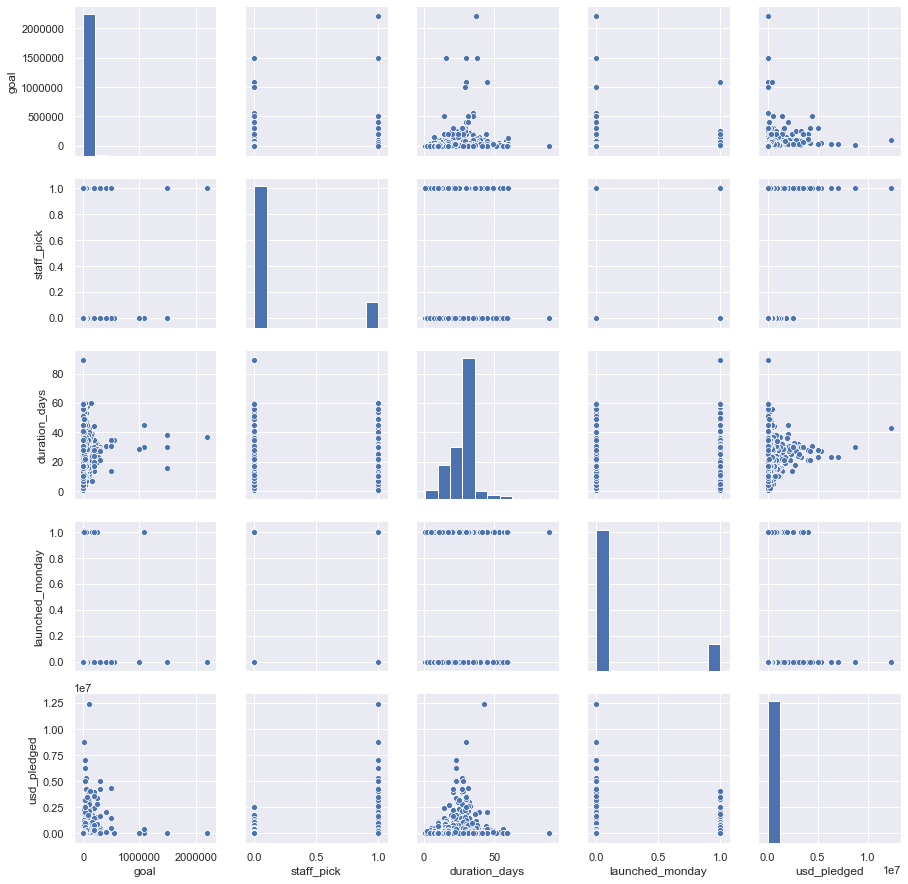

In [152]:
sns.pairplot(df_1)

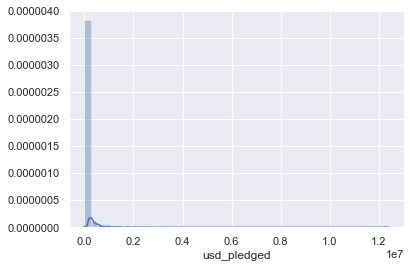

In [150]:
sns.distplot(df_1['usd_pledged'])

In [158]:
X = df_1[[
    'goal',
    'staff_pick',
    'duration_days',
    'launched_monday',
    'launched_tuesday',
    'launched_wednesday', 
    'launched_thursday', 
    'launched_friday', 
    'launched_saturday', 
    'launched_sunday',
    'deadline_monday',
    'deadline_tuesday',
    'deadline_wednesday', 
    'deadline_thursday', 
    'deadline_friday', 
    'deadline_saturday', 
    'deadline_sunday'
   ]]
y = df_1['usd_pledged']

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=666)

In [160]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm.score(X_train, y_train)

0.09736430819400965

In [161]:
lm.score(X_test, y_test)

0.09925494323369055

# y = percent_funded